# Usage Examples for `MDDC` in Python

Authors: Raktim Mukhopadhyay, Anran Liu, Marianthi Markatou

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from IPython.display import display, Markdown

current_date = datetime.now().strftime("%d %B, %Y")
display(Markdown(f"**Date Updated:** {current_date}"))

**Date Updated:** 08 August, 2024

In [2]:
import MDDC

MDDC.__version__

'1.0.dev0'

## Introduction

This vignette contains various examples that illustrate usage of `MDDC`.

### Installation

The `MDDC` package is available on PyPI and can be installed using `pip`. Additionally, the development version can be found on [GitHub](https://github.com/rmj3197/MDDC). 

## Dataset

We have included an adverse event dataset curated from FDA Adverse Event Reporting System (FAERS) called `statin49` dataset which we will be using for describing the functionalities of `MDDC`. `statin49` was downloaded and processed from the FAERS database, covering the period from the third quarter of 2014 (Q3 2014) to the fourth quarter of 2020 (Q4 2020). This dataset is a $50 \times 7$ contingency table. The first 49 rows represent 49 important AEs associated with the statin class, while the final row aggregates the remaining 5,990 AEs. 

In [3]:
statin49 = MDDC.datasets.load_statin49_data()

In [4]:
statin49.head()

,Atorvastatin,Fluvastatin,Lovastatin,Pravastatin,Rosuvastatin,Simvastatin,Other
Rhabdomyolysis,2041,52,44,163,936,1376,31707
Muscle Disorder,291,2,7,21,191,87,7329
Muscle Fatigue,85,0,2,16,30,39,4257
Muscle Haemorrhage,24,0,0,5,13,4,3806
Muscle Necrosis,68,2,0,1,10,20,662


In [5]:
statin49_cluster_idx = MDDC.datasets.load_statin49_cluster_idx_data()

In [6]:
statin49_cluster_idx.head()

,cluster_idx,Atorvastatin,Fluvastatin,Lovastatin,Pravastatin,Rosuvastatin,Simvastatin,Other
Rhabdomyolysis,1,2041,52,44,163,936,1376,31707
Muscle Disorder,1,291,2,7,21,191,87,7329
Muscle Fatigue,1,85,0,2,16,30,39,4257
Muscle Haemorrhage,1,24,0,0,5,13,4,3806
Muscle Necrosis,1,68,2,0,1,10,20,662


## Adverse Event (AE) identification with MDDC

### Using Boxplot Method 

In [7]:
boxplot_results = MDDC.MDDC.mddc(
    contin_table=statin49,
    method="boxplot",
    col_specific_cutoff=True,
    separate=True,
    if_col_corr=False,
    corr_lim=0.8,
)

In [8]:
print(
    f"The boxplot method result contains the following components:{boxplot_results._fields}"
)

The boxplot method result contains the following components:('signal', 'corr_signal_pval', 'corr_signal_adj_pval')


MDDC with boplot method function outputs a list with three components as seen above:

- `boxplot_signal`: An $I \times J$ data matrix with entries 1 or 0, indicating the signals identified in step 2. A value of 1 indicates signals, 0 indicates no signal.
- `corr_signal_pval`: An $I \times J$ data matrix of p-values for each cell in the contingency table from step 5, when the $r_{ij}$ values are mapped back to the standard normal distribution.
- `corr_signal_adj_pval`: An $I \times J$ data matrix of the Benjamini-Hochberg adjusted p-values for each cell in step 5. Users can choose whether to use `corr_signal_pval` or `corr_signal_adj_pval`, and can set their own p-value threshold (for example, 0.05).


Below, we display the first few rows and columns for each component of `boxplot_result`. 

In [9]:
boxplot_results.signal.head(6)

,Atorvastatin,Fluvastatin,Lovastatin,Pravastatin,Rosuvastatin,Simvastatin,Other
Rhabdomyolysis,1,0,0,1,1,1,0
Muscle Disorder,0,0,0,0,1,0,0
Muscle Fatigue,0,0,0,0,0,0,0
Muscle Haemorrhage,0,0,0,0,0,0,0
Muscle Necrosis,0,0,0,0,0,0,0
Muscle Rupture,0,0,0,1,0,0,0


In [10]:
boxplot_results.corr_signal_pval.round(3).head(6)

,Atorvastatin,Fluvastatin,Lovastatin,Pravastatin,Rosuvastatin,Simvastatin,Other
Rhabdomyolysis,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Muscle Disorder,0.527,0.974,0.178,0.545,0.000,0.618,0.783
Muscle Fatigue,0.556,0.834,0.252,0.061,0.656,0.554,0.428
Muscle Haemorrhage,0.561,0.635,0.521,0.307,0.570,0.673,0.387
Muscle Necrosis,0.534,0.186,0.869,0.835,0.677,0.509,0.301
Muscle Rupture,0.569,0.019,0.999,0.000,0.678,0.489,0.915


In this output, we observe that the first row, corresponding to the adverse event *Rhabdomyolysis*, does not have associated p-values. This is because, in step 2 of the algorithm, *Rhabdomyolysis* was already identified as an AE signal for Atorvastatin, Pravastatin, Rosuvastatin, and Simvastatin. Consequently, the standardized Pearson residual values for these four drugs were replaced with NA. With only two residual values remaining in the first row, it was not possible to find connected AEs for *Rhabdomyolysis*. Therefore, this adverse event was excluded from the subsequent steps of the analysis. 

Note that for computing Pearson correlation in step 3, at least three values are required in the matching positions. Applying a p-value threshold of 0.05, we identify the following pairs as signals by considering AE correlations: 

- (Muscle Rupture, Fluvastatin)
- (Muscle Rupture, Pravastatin)
- (Muscle Disorder, Rosuvastatin)

### Using Monte Carlo Method

In [11]:
mc_results = MDDC.MDDC.mddc(
    contin_table=statin49,
    method="monte_carlo",
    rep=10000,
    exclude_same_drug_class=True,
    col_specific_cutoff=True,
    separate=True,
    if_col_corr=False,
    corr_lim=0.8,
)

In [12]:
print(
    f"The Monte Carlo method result contains the following components:{mc_results._fields}"
)

The Monte Carlo method result contains the following components:('pval', 'signal', 'fisher_signal', 'corr_signal_pval', 'corr_signal_adj_pval')


- `pval`: Returns the p-values for each cell in step 2. For cells with counts greater than five, the p-values are obtained via the Monte Carlo (MC) method. For cells with counts less than or equal to five, the p-values are obtained via Fisher's exact tests.
- `signal:`: Indicates signals for cells with counts greater than five, identified in step 2 by the MC method. A value of 1 indicates a signal, while 0 indicates no signal.
- `fisher_signal`: Indicates signals for cells with counts less than or equal to five, identified in step 2 by Fisher's exact tests. A value of 1 indicates a signal, while 0 indicates no signal.
- `corr_signal_pval`: Returns the p-values for each cell in the contingency table in step 5, where the $r_{ij}$ values are mapped back to the standard normal distribution.
- `corr_signal_adj_pval`: Returns the Benjamini-Hochberg adjusted p-values for each cell in step 5. Users can choose whether to use `corr_signal_pval` or `corr_signal_adj_pval`, and select an appropriate p-value threshold (for example, 0.05).


## Function for Reporting 

For ease of use and understanding the identified signals, we have also included a utility function which extracts the signals from
the signal matrix and constructs a dataframe. 

The function `report_drug_AE_pairs()` displays the identified (AE, drug) pairs as well as the observed count, expected count, and the standardized Pearson residuals for the pairs. This function takes two arguments:

- `contin_table`: A data matrix representing an $I \times J$ contingency table, with rows corresponding to adverse events and columns corresponding to drugs.
- `contin_table_signal`: A data matrix with the same dimensions and row and column names as `contin_table`. Entries should be either 1 (indicating a signal) or 0 (indicating no signal). This matrix can be obtained by applying the `MDDC.MDDC.mddc()` functions to `contin_table`.


In [13]:
report_df = MDDC.utils.report_drug_AE_pairs(statin49, mc_results.signal)

report_df.head()

,Drug,AE,Observed Count,Expected Count,Standard Pearson Residual
0,Atorvastatin,Rhabdomyolysis,2041,112.0567,182.5555
1,Atorvastatin,Muscle Disorder,291,24.4606,53.9791
2,Atorvastatin,Muscle Fatigue,85,13.6650,19.3279
3,Atorvastatin,Muscle Haemorrhage,24,11.8848,3.5198
4,Atorvastatin,Muscle Necrosis,68,2.3541,42.8516


## Simulating datasets with grouped AEs

- `contin_table`: A data matrix representing an $I \times J$ contingency table with rows corresponding to adverse events and columns corresponding to drugs. The row and column marginals are used to generate the simulated data.
- `signal_mat`: A data matrix of the same dimensions as the contingency table with entries indicating the signal strength. Values must be greater than or equal to 1, where 1 indicates no signal, and values greater than 1 indicate a signal.
- `cluster_idx`: A numpy.ndarray, list or pandas.DataFrame denoting the cluster index of the various AEs. 
- `n`: The number of simulated contingency tables to be generated.
- `rho`: A numeric value representing the correlation of the AEs within each cluster. The default is 0.5.
- `n_job:`: n_jobs specifies the maximum number of concurrently running workers.
- `seed`:  Random seed for reproducibility of the simulation.

In [14]:
contin_table = statin49_cluster_idx.drop(columns=["cluster_idx"])
cluster_idx = statin49_cluster_idx["cluster_idx"].to_list()
signal_mat = pd.DataFrame(np.ones(contin_table.shape))
signal_mat.columns = list(contin_table.columns)
signal_mat.index = list(contin_table.index)

# A signal of strength 4 is embedded in Rhabdomyolysis for Atorvastatin
signal_mat.at["Rhabdomyolysis", "Atorvastatin"] = 4

In [15]:
simulated_datasets = MDDC.utils.generate_contin_table_with_clustered_AE(
    contin_table, signal_mat, cluster_idx, n=3, seed=42
)

In [16]:
mc_results_with_sim_data = MDDC.MDDC.mddc(simulated_datasets[0], method="monte_carlo")

In [17]:
mc_report_with_sim_datasets_df = MDDC.utils.report_drug_AE_pairs(
    simulated_datasets[0], mc_results_with_sim_data.signal
)

mc_report_with_sim_datasets_df

,Drug,AE,Observed Count,Expected Count,Standard Pearson Residual
0,Atorvastatin,Rhabdomyolysis,426.0,113.2795,29.4359


In the above output, we can see that the identified signal pair is (Atorvastatin, Rhabdomyolysis) which matches the signal embedded previously.

## Visualization

We have also included heatmap visulizations as a part of our package to help visualize the identified signals or p-values. 

This function takes the following arguments: 
- `data:` The data to be plotted as a heatmap. This attribute should be a numpy.ndarray or pandas.DataFrame.
- `size_cell:` The size of each cell in the heatmap, which affects the dimensions of the resulting plot.

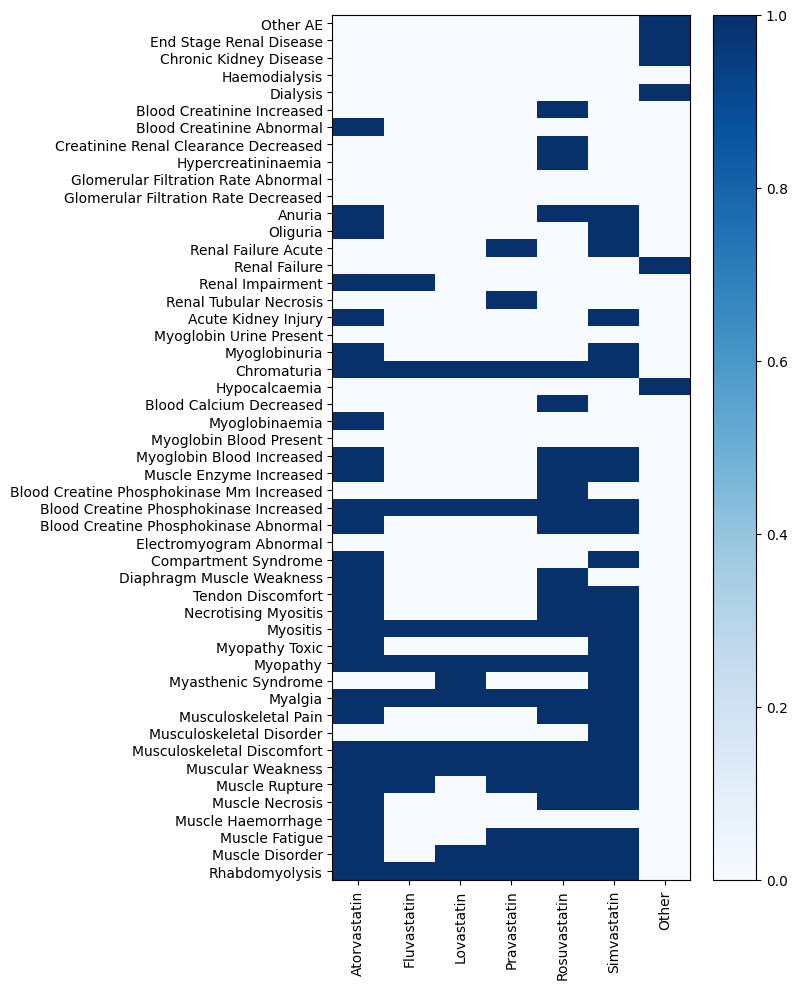

In [18]:
# visualizing the identified signals
MDDC.utils.plot_heatmap(mc_results.signal, cmap="Blues")

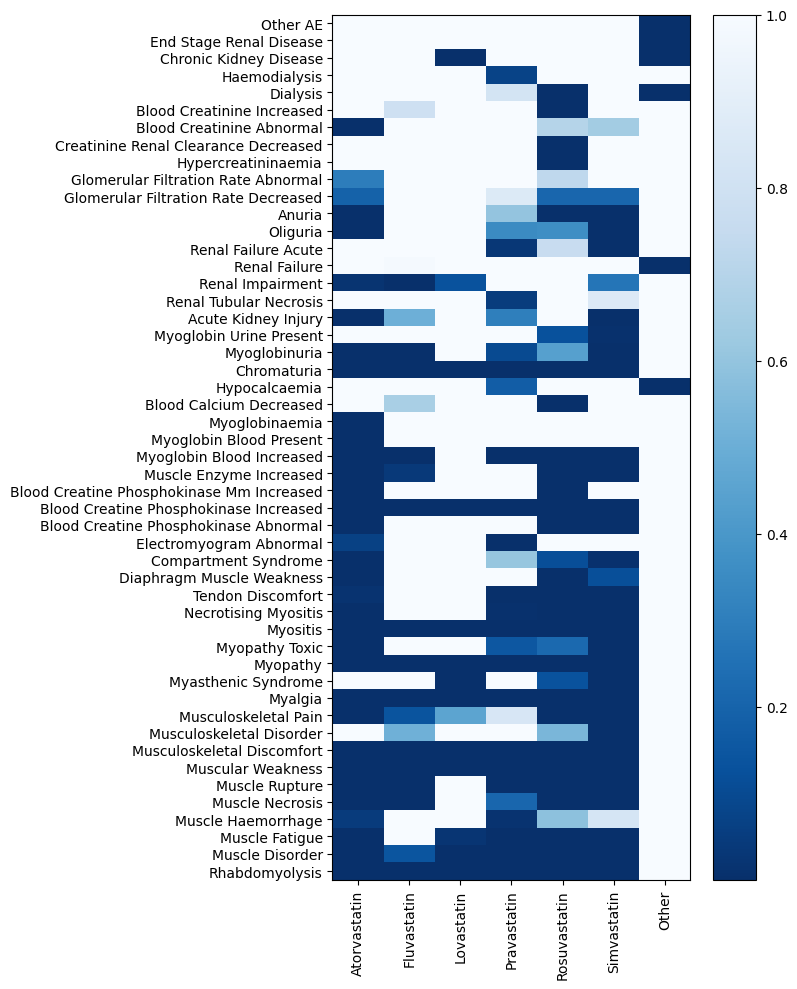

In [19]:
# visualizing the p-values
MDDC.utils.plot_heatmap(mc_results.pval, cmap="Blues_r")